In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd()
if (ROOT / "src").exists() is False and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.viz import *
from src.utils import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

DATA

In [3]:
store_sales = pd.read_csv(
    ROOT / "Data/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr' : 'category',
        'family' : 'category',
        'sales' : 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format = True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()


family_sales = (
    store_sales.groupby(['family','date']).mean().unstack('family').loc['2017']
)

In [4]:
class HybridModel:
    
    def __init__(self, model1, model2):
        self.model1 = model1
        self.model2 = model2
        self.y_columns = None

    def fit(self, X_1, X_2, y):
        self.model1.fit(X_1,y)

        y_fit = pd.DataFrame(self.model1.predict(X_1), index=X_1.index, columns=y.columns)

        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()

        self.model2.fit(X_2,y_resid)

        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid


    def predict(self,X_1,X_2):

        y_pred = pd.DataFrame(self.model1.predict(X_1), index=X_1.index, columns=self.y_columns)

        y_pred = y_pred.stack().squeeze()

        y_pred += self.model2.predict(X_2)

        return y_pred.unstack()


In [5]:
y = family_sales.loc[:,'sales']


dp = DeterministicProcess(
    index = y.index,
    order = 1
)

X_1 = dp.in_sample()

X_2 = family_sales.drop('sales', axis=1).stack()

le = LabelEncoder()
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])
X_2['day'] = X_2.index.day


In [6]:
model_1 = LinearRegression()
model_2 = XGBRegressor()
model = HybridModel(model_1,model_2)

model.fit(X_1 = X_1, X_2 = X_2, y = y)

y_pred = model.predict(X_1 = X_1, X_2 = X_2).clip(0.0)



In [7]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)


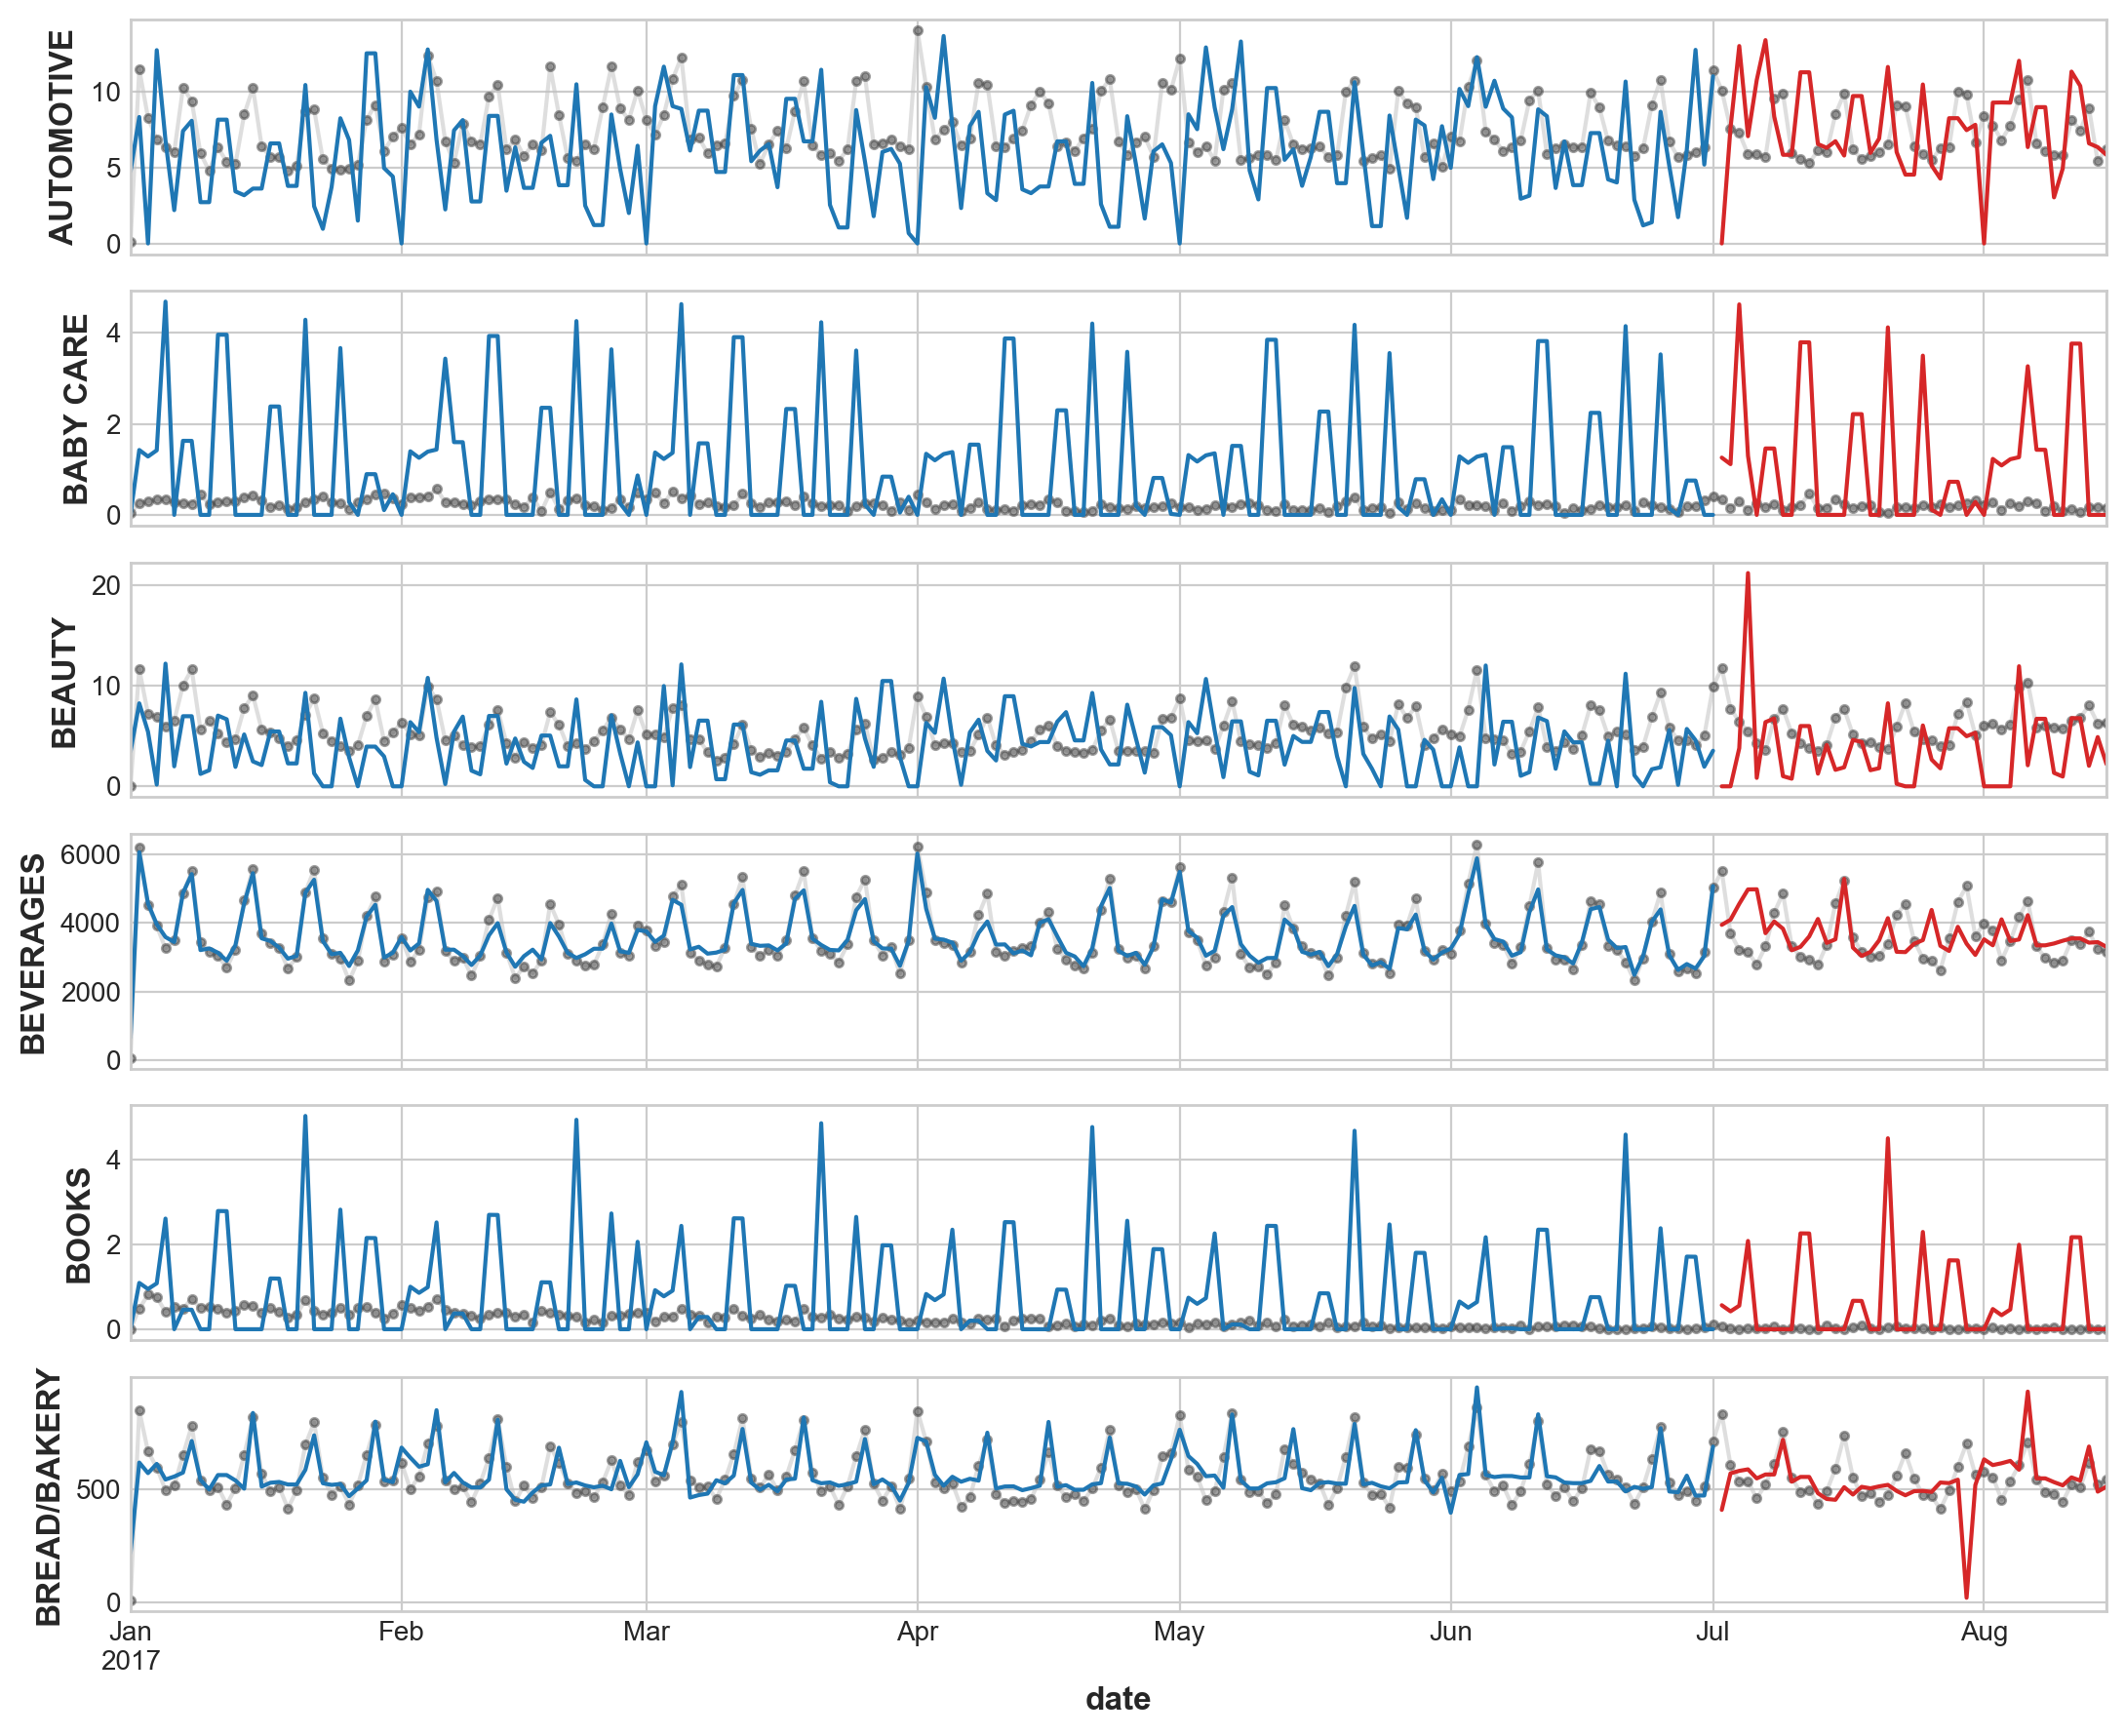

In [8]:
families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

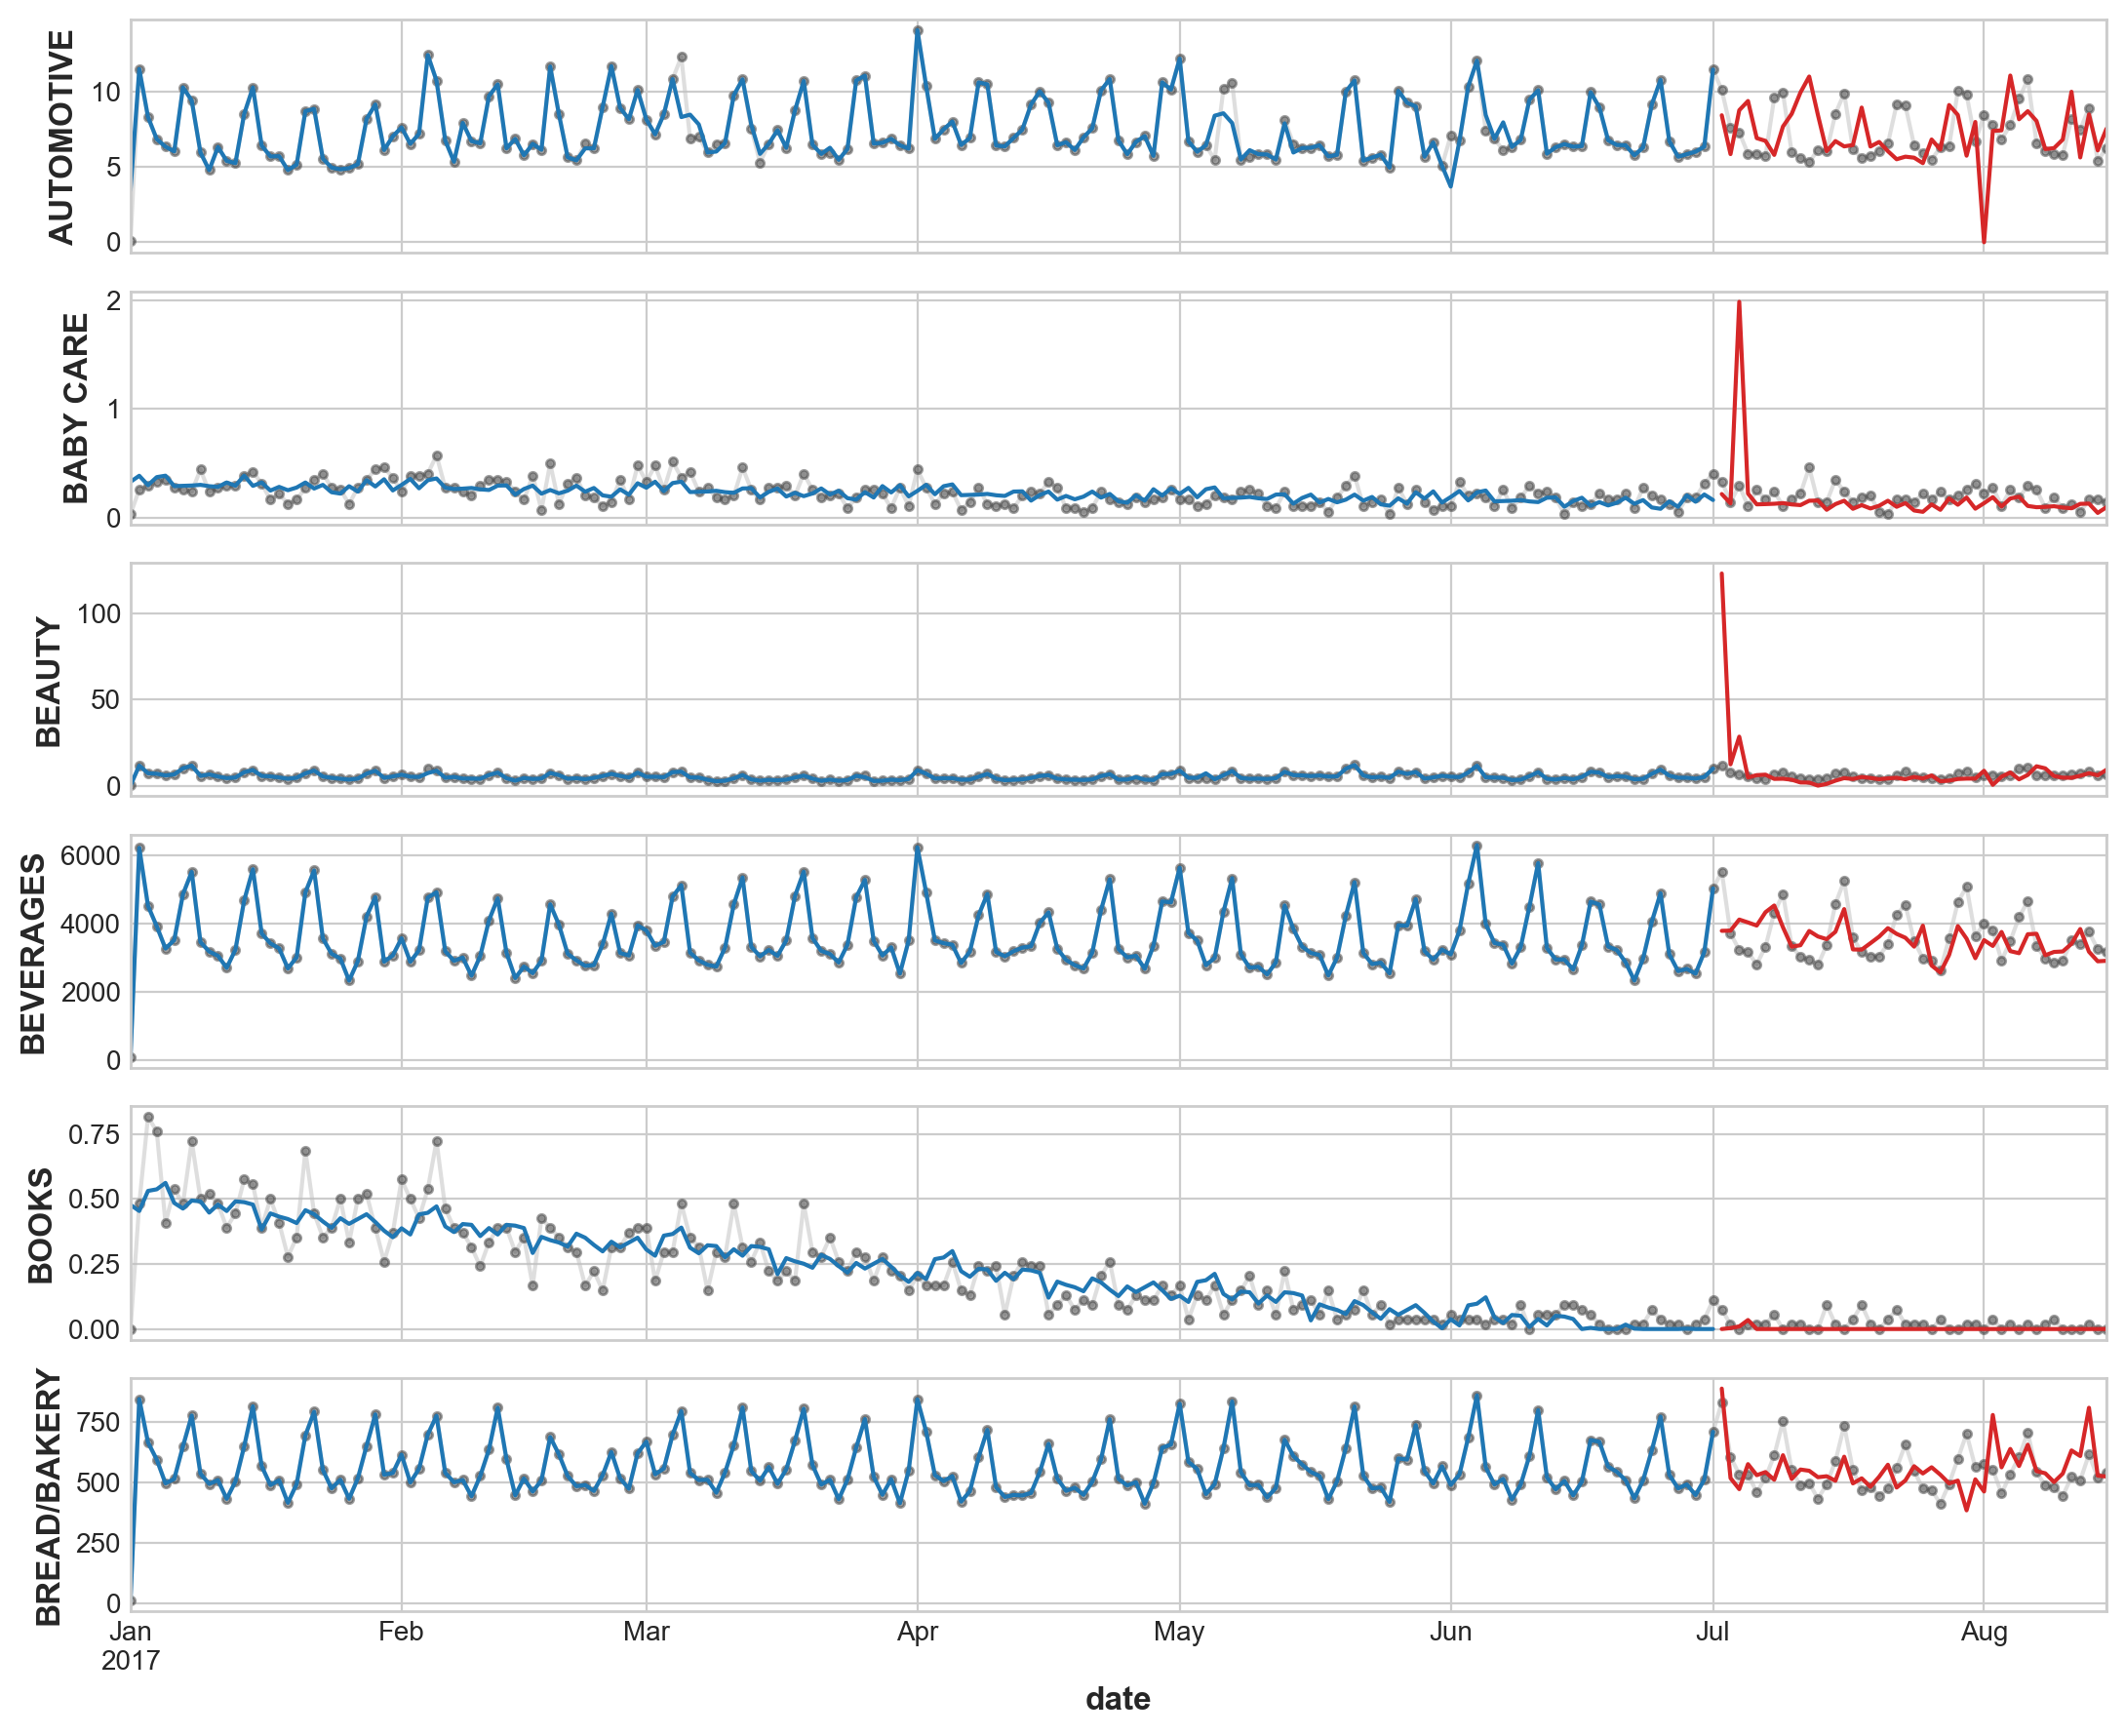

In [9]:
model0 = HybridModel(Ridge(),ExtraTreesRegressor())

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]


model0.fit(X1_train, X2_train, y_train)
y_fit0 = model0.predict(X1_train, X2_train).clip(0.0)
y_pred0 = model0.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit0.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred0.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)
